### **PROJECT TITLE- Rice Leaf Disease Detection using Deep Learning**



##### **Domain-** Deep Learning, Computer Vision

##### **Field of Application-**  Agriculture, Policy makers(Government)


#### Overview:  
   * Rice is one of the most important food crops. It is crucial staple food feeding millions and one of the major driving force in the indian economy.
   * Diseases affecting rice leaves can significantly reduce crop yield.
   * Manual identification of diseases is time-consuming and error-prone. hence,
   * This project aims to classify three major rice leaf diseases:
       1) Bacterial leaf blight
       2) Brown spot
       3) Leaf smut

     using Convolutional Neural Networks (CNN).

### **PHASE 1: Project Initialization**

#### **STEP 1: Importing necessesary Libraries and loading our dataset**

In [1]:
import keras
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
base_path=r"D:\DATAMITES PROJECTS\Projects\PRCP-1001-RiceLeaf\Data"
classes = {
    'Bacterial leaf blight': os.path.join(base_path,"Bacterial leaf blight"),
    "Brown spot": os.path.join(base_path,"Brown spot"),
    "Leaf smut": os.path.join(base_path,"Leaf smut")
}


for class_name, path in classes.items():
    image_count = len(os.listdir(path))
    print(f"{class_name}: {image_count} images")


Bacterial leaf blight: 40 images
Brown spot: 40 images
Leaf smut: 39 images


#### **Basic Inference from the Dataset**


* During dataset verification, it was observed that the Leaf smut class contains
39 images, while the other two classes contain 40 images each. This results in a
minor class imbalance.

* Since the difference is minimal, the imbalance is handled using data
augmentation techniques during model training.

#### **STEP 2: Exploratory Data Analysis (EDA)**

The dataset consists of images of rice leaves affected by different diseases. Each image belongs to one of the disease categories, and the objective is to classify the disease type based on visual symptoms present on the leaf surface. The dataset contains a limited number of images per class, making exploratory data analysis crucial to understand dataset characteristics and potential challenges such as overfitting.



#### **1) Sample Image Visualization:**
* Human-level understanding

* Visual differences between diseases

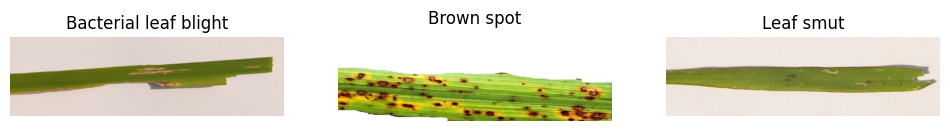

In [3]:
plt.figure(figsize=(12,4))

for idx, (class_name, path) in enumerate(classes.items()):
    img_name = os.listdir(path)[0]
    img_path = os.path.join(path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, idx+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.show()


#### **2) Image Property Analysis:**


In [4]:

image_paths = []
labels = []

for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img_name))
            labels.append(class_name)

image_data = []

for img_path in image_paths:
    with Image.open(img_path) as img:
        img = img.convert("RGB")
        width, height = img.size
        img_array = np.array(img)
        mean_r = img_array[:, :, 0].mean()
        mean_g = img_array[:, :, 1].mean()
        mean_b = img_array[:, :, 2].mean()
        
        image_data.append([width, height, mean_r, mean_g, mean_b])

df_images = pd.DataFrame(
    image_data,
    columns=["Width", "Height", "Mean_R", "Mean_G", "Mean_B"]
)

df_images.head()


,Width,Height,Mean_R,Mean_G,Mean_B
0,3081,897,196.812530,187.389357,163.829316
1,3081,897,194.011853,185.148399,159.366644
2,3081,897,196.324843,189.773938,154.972565
3,3081,897,174.996505,171.419818,131.220349
4,3081,897,190.699627,186.265722,143.515217


#### **Observation:**
  * All images are high resolution (3081×897)
  * Color channels show natural variation,
    which confirms:
      * Need for resizing
      * Need for normalization
      * Need for augmentation
  * In addition to visual inspection of sample images, numerical analysis of image properties was performed to better understand dataset characteristics. 
  * Image dimensions and color channel distributions were analyzed to assess consistency and justify preprocessing steps such as resizing and normalization.

#### **3) Image Width and Height Distribution:**

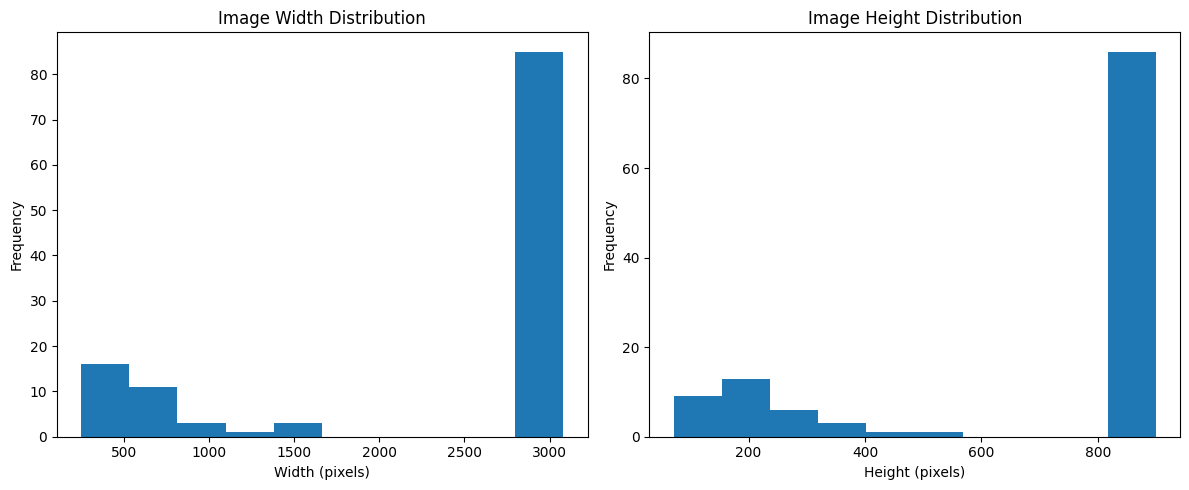

In [5]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_images["Width"], bins=10)
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(df_images["Height"], bins=10)
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


#### **Observation:**  

1) Width distribution:
   * A large concentration around ~3000 pixels
   * A smaller group between ~300–800 pixels
   * A few mid-range widths (~1200–1600 pixels)

2) Height distribution:
   * A dominant peak around ~850–900 pixels
   * Smaller clusters around ~150–300 pixels
   * Very few samples in mid ranges

This indicates multiple image resolutions, not a single standardized size.


#### **4) Color Channel Distribution:**

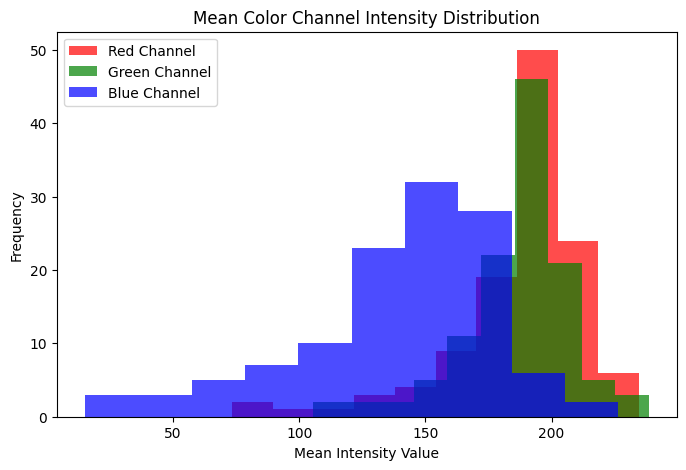

In [6]:
plt.figure(figsize=(8, 5))

plt.hist(
    df_images["Mean_R"],
    bins=10,
    alpha=0.7,
    label="Red Channel",
    color="red"
)

plt.hist(
    df_images["Mean_G"],
    bins=10,
    alpha=0.7,
    label="Green Channel",
    color="green"
)

plt.hist(
    df_images["Mean_B"],
    bins=10,
    alpha=0.7,
    label="Blue Channel",
    color="blue"
)

plt.title("Mean Color Channel Intensity Distribution")
plt.xlabel("Mean Intensity Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


#### **Observation:**

1) Red channel:

   * Concentrated at higher intensity values (~180–210)

2) Green channel:

   * Slightly lower than red, clustered around ~170–200
   * Leaves are green dominant.

3) Blue channel:

   * Much broader spread, including low intensity values (~30–150)
   * Blue channel is more affected by lighting, shadows, and background



----------------------------------------------------------------------------------------------------------------------------------

### **PHASE 2 : Data Preprocessing**

Before model training, several preprocessing steps were to be applied in order to prepare the rice leaf images for effective learning by deep learning models. These steps were designed based on insights obtained from exploratory data analysis and common best practices for image-based classification tasks.

* #### Image Resizing:
The images in the dataset should be resized to a fixed resolution during data loading. Since the original images varied in size, resizing ensures uniform input dimensions across all samples, which is a requirement for batch processing in convolutional neural networks.

* #### Image Normalization:
Pixel values in the original images range from 0 to 255. A Rescaling layer was to be applied to normalize pixel intensities to the range [0, 1]. This normalization improves numerical stability during training, enables faster convergence, and helps prevent issues related to exploding or vanishing gradients.

* #### Data Augmentation:
Due to the relatively small size of the dataset (119 images), data augmentation techniques were to be applied to artificially increase the diversity of training samples. Augmentation operations such as random rotations, flips, and zooming simulate real-world variations in leaf orientation, scale, and camera angles. This helps the model generalize better and reduces overfitting.

* #### Train–Validation Split:
The dataset should be divided into training and validation sets to evaluate model performance on unseen data. Validation metrics were monitored during training to assess generalization ability and guide model selection.


### 1) Splitting our dataset into training and validation set
**Objective:**
  
  To prepare the dataset for training by:
   * Splitting into Train / Validation.
   * Avoiding data leakage
   * Note: A separate test set was not created due to the limited dataset size.

In [7]:
import keras
BATCH_SIZE = 16
IMAGE_SIZE = (224,224)
SEED = 42

train_ds = keras.utils.image_dataset_from_directory(    # training set
    directory=base_path,
    labels="inferred",
    label_mode="categorical",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

Found 119 files belonging to 3 classes.
Using 96 files for training.


In [8]:
val_ds = keras.utils.image_dataset_from_directory(    # validation set
    directory=base_path,
    labels="inferred",
    label_mode="categorical",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)

Found 119 files belonging to 3 classes.


Using 23 files for validation.


#### 2) Performance Optimization
Dataset performance is optimized by prefetching in order
to improve training speed.

In [9]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

----------------------------------------------------------------------------------------------------------------------------------

### **PHASE 3: Model Building**


#### EXPERIMENT 1 : BUILDING A BASELINE CNN MODEL


1) **Objective :**

The goal is to build a baseline Convolutional Neural Network (CNN) model in order to establish a reference before applying advanced techniques such as data augmentation,regularization,transfer learning.


2) **Architecture :**

The baseline CNN consists of:
   - Input normalization
   - Convolution + MaxPooling blocks
   - Fully connected layers
   - Softmax output for multi-class classification.

In [ ]:
from keras import layers, models

NUM_CLASSES = 3

inputs = layers.Input(shape=(224, 224, 3))

# normalization
x = layers.Rescaling(1./255)(inputs)

# Conv Block 1
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)

# Conv Block 2
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)

# Conv Block 3
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)

# Classifier
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_no_aug = models.Model(inputs, outputs)


In [ ]:
# Compilation process
model_no_aug.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Training process
first_model_no_aug = model_no_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 414ms/step - accuracy: 0.4271 - loss: 2.3542 - val_accuracy: 0.2174 - val_loss: 1.6826
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - accuracy: 0.4479 - loss: 1.0324 - val_accuracy: 0.5217 - val_loss: 0.9856
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 0.5417 - loss: 0.8561 - val_accuracy: 0.4348 - val_loss: 1.0819
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - accuracy: 0.6146 - loss: 0.8188 - val_accuracy: 0.4783 - val_loss: 1.0929
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 0.6562 - loss: 0.7425 - val_accuracy: 0.7391 - val_loss: 0.7548
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - accuracy: 0.7812 - loss: 0.6000 - val_accuracy: 0.6087 - val_loss: 0.9911
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - accuracy: 0.7500 - loss: 0.5869 - val_accuracy: 0.7826 - val_loss: 0.7442
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.8021 - loss: 0.5102 - val_accuracy: 0.7826 - val_loss:

***INSIGHT:***
     
   * This is the classic example for overfitting.
   * The model trained and achieved nearly 100% training accuracy but showed poor generalization, 
with validation accuracy dropping to approximately 70% and validation loss increasing significantly. 
This indicates severe overfitting.
   * The training loss decreased sharply, while the validation loss fluctuated and remained comparatively high.


   -------------------------------------------------------------------------------------------------------------------------------


#### EXPERIMENT 2: Building a CNN with DATA AUGMENTATION


1) **Objective :** 

Previous model was severly affected by over fitting issue thus 
to overcome this problem we use data augmentation technique which used to analyze new variations at every epoch and also learns robust features.


2) **The following data augmentation techniques are applied:**

    - Random horizontal flipping
    - Random rotation
    - Random zoom
    - Random contrast adjustment

These transformations simulate real-world variations such as camera
angle changes, leaf orientation, and lighting conditions.

In [9]:
# Data Augmentation technique

from keras import layers

augment_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
]

In [14]:
from keras import layers, models

NUM_CLASSES = 3

inputs = layers.Input(shape=(224, 224, 3))

x = inputs

# Data augmentation (training only)
for aug in augment_layers:
    x = aug(x)

# Normalization
x = layers.Rescaling(1./255)(x)

# Conv Block 1
x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2,2)(x)

# Conv Block 2
x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2,2)(x)

# Conv Block 3
x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2,2)(x)

# Classifier
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model_aug = models.Model(inputs, outputs)


In [ ]:
# Compilation process
model_aug.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# Training process
second_model_aug = model_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.2917 - loss: 3.0330 - val_accuracy: 0.2174 - val_loss: 1.1135
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 0.3646 - loss: 1.1049 - val_accuracy: 0.2174 - val_loss: 1.1428
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - accuracy: 0.4062 - loss: 1.0748 - val_accuracy: 0.3478 - val_loss: 1.1337
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - accuracy: 0.4167 - loss: 1.0376 - val_accuracy: 0.3478 - val_loss: 1.1856
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 380ms/step - accuracy: 0.4792 - loss: 0.9857 - val_accuracy: 0.3478 - val_loss: 1.0567
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - accuracy: 0.4792 - loss: 0.9885 - val_accuracy: 0.3478 - val_loss: 1.1249
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.5729 - loss: 0.9568 - val_accuracy: 0.3043 - val_loss: 1.3407
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.5417 - loss: 0.9128 - val_accuracy: 0.4348 - val_loss:

***INSIGHT:***

Experimental results show that data augmentation plays a critical role in improving model generalization. While the CNN trained on original images suffered from overfitting, the augmented model achieved noticeably better validation performance.

----------------------------------------------------------------------------------------------------------------------------------


#### EXPERIMENT 3: CNN with REGULARIZATION

1) **Objectives:**
    * Reduce overfitting further
    * Stabilize training
    * Improve consistency across runs


2) **The following Regularization techniques are applied:**

    * Dropout
    * Batch normalization

In [17]:
from keras import layers, models

NUM_CLASSES = 3

inputs = layers.Input(shape=(224, 224, 3))

x = inputs

#  Data Augmentation (training only)
x = layers.RandomFlip("horizontal")(x)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)
x = layers.RandomContrast(0.1)(x)

#  Normalization
x = layers.Rescaling(1./255)(x)

#  Conv Block 1
x = layers.Conv2D(32, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(2,2)(x)

#  Conv Block 2
x = layers.Conv2D(64, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(2,2)(x)

#  Conv Block 3
x = layers.Conv2D(128, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(2,2)(x)

#  Classifier
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)   #  Regularization
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model_reg = models.Model(inputs, outputs)


In [ ]:
# Compilation process
model_reg.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Training process
third_model_reg=model_reg.fit(train_ds,validation_data=val_ds,epochs=20)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 878ms/step - accuracy: 0.3750 - loss: 49.4995 - val_accuracy: 0.3043 - val_loss: 1.9046
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 724ms/step - accuracy: 0.5208 - loss: 9.8300 - val_accuracy: 0.1304 - val_loss: 1.4695
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 710ms/step - accuracy: 0.5938 - loss: 7.8373 - val_accuracy: 0.2174 - val_loss: 3.9896
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 750ms/step - accuracy: 0.7188 - loss: 6.3108 - val_accuracy: 0.2174 - val_loss: 7.5106
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 787ms/step - accuracy: 0.6875 - loss: 3.7602 - val_accuracy: 0.2174 - val_loss: 6.2269
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 684ms/step - accuracy: 0.6667 - loss: 2.6373 - val_accuracy: 0.2174 - val_loss: 8.7592
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 718ms/step - accuracy: 0.6979 - loss: 2.3368 - val_accuracy: 0.2174 - val_loss: 5.9677
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 700ms/step - accuracy: 0.6562 - loss: 1.6276 - val_accuracy: 0.2174 - val_loss

***INSIGHT:***


   * Although regularization is effective in controlling overfitting, its application on a small dataset led to underfitting by over constraining the model, resulting in reduced validation performance.
   * Due to the small dataset size and limited batch
statistics, the model showed training instability and underfitting.
   * This experiment demonstrates that excessive regularization can be detrimental
for the small datasets.


----------------------------------------------------------------------------------------------------------------------------------


#### EXPERIMENT 4: Building a model with Transfer Learning technique


1) **Objective:**

   * To implement MobileNet as a pretrained feature extractor to enhance classification performance and stability when training   on a small image dataset.

2) **Transfer Learning:**
   * Transfer learning leverages knowledge learned from large-scale datasets.

3) **MobileNet:**
    * MobileNet is a lightweight pre-trained convolutional neural network designed for efficient image classification
    * Pretrained on ImageNet (millions of images)
    * Learns strong generic visual features
    * Works well even with small datasets
    * Fewer parameters than VGG/ResNet
    * Faster training
    * Lower overfitting risk

In [20]:
from keras.applications import MobileNet
from keras import layers, models


In [21]:
base_model = MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,      # remove ImageNet classifier
    weights="imagenet"
)

base_model.trainable = False
inputs = layers.Input(shape=(224, 224, 3))

# Data augmentation
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)

# MobileNet preprocessing
x = layers.Rescaling(1./255)(x)

# Feature extractor
x = base_model(x, training=False)

# Custom classifier
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model_mobilenet = models.Model(inputs, outputs)


In [ ]:
# Compilation process
model_mobilenet.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# Training process
fourth_model_mobilenet = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.5833 - loss: 0.9813 - val_accuracy: 0.6087 - val_loss: 0.9456
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.7812 - loss: 0.5243 - val_accuracy: 0.6522 - val_loss: 0.8452
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.8542 - loss: 0.4349 - val_accuracy: 0.6957 - val_loss: 0.7462
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.8854 - loss: 0.3202 - val_accuracy: 0.8261 - val_loss: 0.6040
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.9271 - loss: 0.1861 - val_accuracy: 0.7391 - val_loss: 0.5947
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.9271 - loss: 0.2076 - val_accuracy: 0.8261 - val_loss: 0.5439
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.9479 - loss: 0.1402 - val_accuracy: 0.8261 - val_loss: 0.5004
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.9583 - loss: 0.1152 - val_accuracy: 0.8696 - val_loss:

***INSIGHT:*** 

1) Fast convergence

* Validation accuracy jumps from 52% → 78% → 87% → 91%.
* Happens within 5–9 epochs.

2) Strong generalization

* Validation loss continuously decreases.
* No sudden explosion like earlier regularized CNN.
* Minor fluctuations are normal due to small data.

3) Mild overfitting, but controlled

* Training accuracy goes close to 100%.
* Validation accuracy stays high 87% (approx).


MobileNet was pre-trained on ImageNet and already learned generic
low-level and mid-level visual features. Using it as a frozen feature
extractor allowed the model to generalize better on a small dataset.


----------------------------------------------------------------------------------------------------------------------------------


### **Hyperparameter Selection and Design Rational:**

The models were designed using a progressive approach, starting from a simple baseline CNN and gradually incorporating techniques such as data augmentation, regularization, and transfer learning. This strategy allows clear observation of how each technique contributes to performance improvement.

#### 1) Optimizer Selection:
The Adam optimizer was chosen due to its adaptive learning rate mechanism, which combines the advantages of both momentum and RMSProp. Adam performs well for image classification tasks and enables faster convergence, especially when training on relatively small datasets.

#### 2) Learning Rate Considerations
A small learning rate was used to ensure stable convergence during training. This is particularly important for transfer learning models such as MobileNet, where large learning rates may distort pre-trained feature representations.

#### 3) Batch Size and Epochs 
Batch size was selected to balance computational efficiency and stable gradient estimation. The number of training epochs was chosen to allow sufficient learning of features while monitoring validation performance to prevent overfitting.

#### 4) Regularization Techniques  
Dropout layers were introduced in the CNN models to reduce overfitting by preventing co-adaptation of neurons. Regularization proved especially useful given the limited dataset size.

#### 5) Transfer Learning Strategy  
MobileNet was used as a pre-trained feature extractor trained on the ImageNet dataset. Leveraging learned low-level and mid-level features enables better generalization and faster convergence compared to training a deep network from scratch.

----------------------------------------------------------------------------------------------------------------------------------


### **PHASE 4: Final Report**

##### **Report 1: Models built**

   1) A baseline CNN
   2) CNN with Data Augmentation
   3) CNN with Regularization technique
   4) Transfer Learning using MobileNet


##### **Report 2: Model comparison and Performance analysis**

We are comparing the model based on Validation accuracy and validation Loss because validation accuracy tells how well the model classify unseen data and validation loss shows how confident and stable our are the model's prediction.


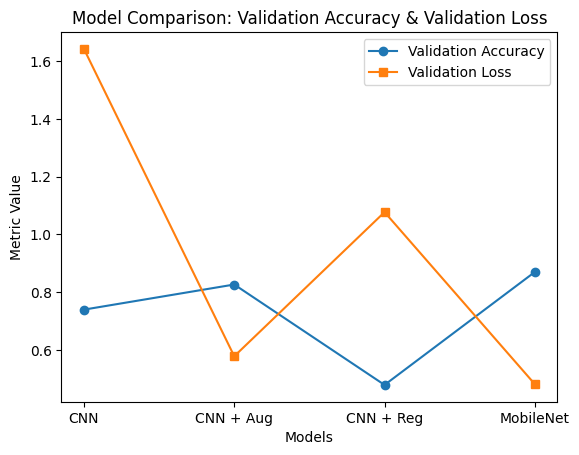

In [15]:
import matplotlib.pyplot as plt
import numpy as np

models = [
    "CNN",
    "CNN + Aug",
    "CNN + Reg",
    "MobileNet"
]

val_accuracy = [0.7391, 0.8261, 0.4783, 0.8696]
val_loss = [1.6422, 0.5776, 1.0769, 0.4808]

x = np.arange(len(models))

plt.figure()

plt.plot(x, val_accuracy, marker='o', label="Validation Accuracy")
plt.plot(x, val_loss, marker='s', label="Validation Loss")

plt.xticks(x, models)
plt.xlabel("Models")
plt.ylabel("Metric Value")
plt.title("Model Comparison: Validation Accuracy & Validation Loss")
plt.legend()
plt.show()


Model 1: Clearly Overfitting due to very high loss with moderate accuracy.

Model 2: balanced but not best

Model 3: severe underfitting due to low accuracy + high loss.

Model 4: MobileNet achieves the highest validation accuracy, proving the effectiveness of transfer learning on small datasets.

#### Final Verdict:

   * Multiple models were evaluated to understand the impact of different techniques on classification performance. The baseline CNN served as a reference model and demonstrated reasonable training accuracy; however, it showed signs of overfitting due to the limited dataset size.

   * The CNN model enhanced with data augmentation exhibited improved validation performance compared to the baseline. Augmentation introduced variability in training samples, helping the model learn more robust features and reducing sensitivity to minor image variations.

   * Incorporating regularization techniques such as dropout expected to perform well but due to small dataset it performs poorly by exhibiting severe underfit.

   * The MobileNet-based transfer learning model achieved the highest validation accuracy among all models. This improvement can be attributed to the use of pre-trained weights learned from the ImageNet dataset, which capture rich and general visual features. Transfer learning significantly reduces the risk of overfitting and enables better performance, particularly when working with small datasets.

Based on the comparative evaluation, the MobileNet model demonstrates the best balance between accuracy and generalization, making it the most suitable candidate for real-world deployment.


#### **Report 3: Challenges faced**

1) Very small Dataset: 
   * Dataset contains only 119 images which is highly difficult to make a stable model.
   * High risk of overfitting and poor generalization.
   * Even Regularization method were severly affected by Underfitting
2) Selecting the Best Model for Production:
   * Custom CNNs struggled due to limited data.
   * Need a model that generalizes well despite small dataset size.
3) Model Comparison:
   * Training metrics were misleading due to overfitting.

----------------------------------------------------------------------------------------------------------------------------------


#### **CONCLUSION:**
* The proposed deep learning–based solution demonstrates the potential of AI-driven tools in supporting precision agriculture.
* In this project, multiple deep learning models were developed and evaluated to classify rice leaf diseases. 
* Among all models, MobileNet with transfer learning achieved the best performance, showing high validation accuracy and low validation loss. 
* The study highlighted the effects of overfitting, underfitting, data augmentation,regularization and transfer learning on small image datasets.

### **Future Scope**
   * Future work can focus on expanding the dataset with a larger number of images collected under diverse field conditions to further improve model generalization. Advanced explainability techniques such as Grad-CAM can be employed to visualize disease-affected regions and enhance model interpretability. Furthermore, deploying the trained model on mobile or edge devices can enable real-time disease detection, supporting farmers with timely diagnosis and decision-making.

----------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# ------------------------------------------------------------
# Loading Trained Models with Pre-trained Parameters
# ------------------------------------------------------------
# This section loads the saved deep learning models that were
# trained using different techniques. These models are reused
# here for evaluation and comparison without retraining.
#
# Models loaded:
# 1. CNN without data augmentation
# 2. CNN with data augmentation
# 3. CNN with regularization
# 4. MobileNet-based transfer learning model
# ------------------------------------------------------------

import tensorflow as tf
from tensorflow.keras.models import load_model

# CNN without augmentation
model_no_aug = load_model('saved_models/cnn_no_augmentation.keras')

# CNN with data augmentation
model_aug = load_model('saved_models/cnn_with_augmentation.keras')

# CNN with regularization
model_reg = load_model('saved_models/cnn_with_regularization.keras')

# MobileNet transfer learning model
model_mobilenet = load_model('saved_models/mobilenet_transfer_learning.keras')
